# 0. Reading the Data
I will start with ride ID = 2975587283 which is the first ride of 2020 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#pd.set_option("display.max_rows", 1000)
pd.set_option("display.max_columns", 100)

In [2]:
file_paths = {'in':'../../data/enriched/activities/2975587283.csv'
             }

df = pd.read_csv(file_paths['in'])

# guarantee the timestamps are datetime objects
df['time'] = pd.to_datetime(df['time'])

In [3]:
df.head()

,time,ride_id,segment_id,elevation,latitude,longitude,elapsed_time,delta_time,moving_time
0,2020-01-02 14:02:58+00:00,2.975587e+09,0.0,224.30,40.042824,-83.027358,1.0,1.0,1.0
1,2020-01-02 14:02:59+00:00,2.975587e+09,0.0,224.25,40.042851,-83.027424,2.0,1.0,2.0
2,2020-01-02 14:03:00+00:00,2.975587e+09,0.0,224.20,40.042877,-83.027490,3.0,1.0,3.0
3,2020-01-02 14:03:01+00:00,2.975587e+09,0.0,224.20,40.042896,-83.027535,4.0,1.0,4.0
4,2020-01-02 14:03:02+00:00,2.975587e+09,0.0,224.20,40.042914,-83.027581,5.0,1.0,5.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1352 entries, 0 to 1351
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   time          1352 non-null   datetime64[ns, UTC]
 1   ride_id       1352 non-null   float64            
 2   segment_id    1352 non-null   float64            
 3   elevation     1352 non-null   float64            
 4   latitude      1352 non-null   float64            
 5   longitude     1352 non-null   float64            
 6   elapsed_time  1352 non-null   float64            
 7   delta_time    1352 non-null   float64            
 8   moving_time   1352 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(8)
memory usage: 95.2 KB


# 1. Calculating Distance Travelled

In [5]:
from haversine import haversine

def compute_distance(df, latitude='latitude', longitude='longitude', fill_first=np.nan):
    df = df.copy()
    # Copy the previous values of Lat/Long to the current row for vectorized computation
    df['lat_old'] = df[latitude].shift()
    df['long_old'] = df[longitude].shift()
    
    # Grab the relevant columns for distance calculation
    df_gps = df[['lat_old', 'long_old', latitude, longitude]]
    
    # Define an anonymous function to execute over each row to calculate the distance between rows
    haversine_distance = lambda x: haversine((x[0], x[1]), (x[2], x[3]), unit='mi')
    
    # Create the distance column, making sure to apply the function row-by-row
    df['delta_dist'] = df_gps.apply(haversine_distance, axis=1)
    df['delta_dist'] = df['delta_dist'].fillna(fill_first)
    
    # Remove the old latitude and longitude columns
    df.drop(['lat_old','long_old'], axis=1, inplace=True)
    return df

In [6]:
df = compute_distance(df)

In [7]:
# compute the cumulative distance elapsed
df['elapsed_distance'] = df['delta_dist'].cumsum()

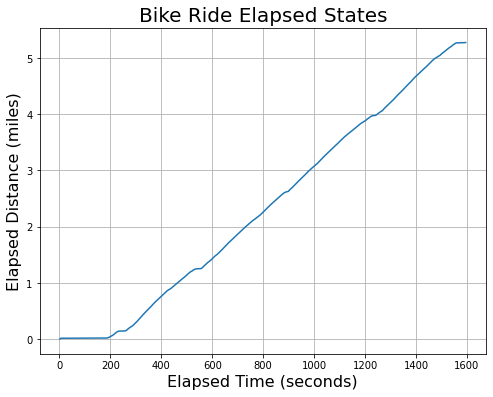

In [8]:
# visualize the jumps of cumulative time 
fig = plt.figure(figsize=(8,6))

_ = plt.plot(df['elapsed_time'], df['elapsed_distance'])
_ = plt.xlabel('Elapsed Time (seconds)', fontsize=16)
_ = plt.ylabel('Elapsed Distance (miles)', fontsize=16)
_ = plt.title('Bike Ride Elapsed States', fontsize=20)
_ = plt.grid()

In [9]:
df.head(2)

,time,ride_id,segment_id,elevation,latitude,longitude,elapsed_time,delta_time,moving_time,delta_dist,elapsed_distance
0,2020-01-02 14:02:58+00:00,2.975587e+09,0.0,224.30,40.042824,-83.027358,1.0,1.0,1.0,NaN,NaN
1,2020-01-02 14:02:59+00:00,2.975587e+09,0.0,224.25,40.042851,-83.027424,2.0,1.0,2.0,0.003942,0.003942


In [10]:
df.tail(10)

,time,ride_id,segment_id,elevation,latitude,longitude,elapsed_time,delta_time,moving_time,delta_dist,elapsed_distance
1342,2020-01-02 14:28:55+00:00,2.975587e+09,3.0,223.8,40.042975,-83.027800,1558.0,1.0,1343.0,0.001125,5.267359
1343,2020-01-02 14:28:56+00:00,2.975587e+09,3.0,223.8,40.042963,-83.027794,1559.0,1.0,1344.0,0.000920,5.268279
1344,2020-01-02 14:28:57+00:00,2.975587e+09,3.0,223.8,40.042950,-83.027788,1560.0,1.0,1345.0,0.000920,5.269200
1345,2020-01-02 14:29:26+00:00,2.975587e+09,4.0,223.8,40.042963,-83.027746,1589.0,1.0,1346.0,0.002396,5.271596
1346,2020-01-02 14:29:27+00:00,2.975587e+09,4.0,223.8,40.042951,-83.027752,1590.0,1.0,1347.0,0.000873,5.272469
1347,2020-01-02 14:29:28+00:00,2.975587e+09,4.0,223.8,40.042940,-83.027759,1591.0,1.0,1348.0,0.000873,5.273342
1348,2020-01-02 14:29:29+00:00,2.975587e+09,4.0,223.8,40.042928,-83.027765,1592.0,1.0,1349.0,0.000873,5.274215
1349,2020-01-02 14:29:30+00:00,2.975587e+09,4.0,223.8,40.042937,-83.027759,1593.0,1.0,1350.0,0.000678,5.274892
1350,2020-01-02 14:29:31+00:00,2.975587e+09,4.0,223.8,40.042945,-83.027753,1594.0,1.0,1351.0,0.000678,5.275570
1351,2020-01-02 14:29:32+00:00,2.975587e+09,4.0,223.8,40.042954,-83.027747,1595.0,1.0,1352.0,0.000678,5.276248


# 2. Speed Calculation

In [11]:
miles_per_second_2_MPH = 3600.0 / 1.0 # conversion factor
df['speed'] = miles_per_second_2_MPH * df['delta_dist'] / df['delta_time']

### Visualizing Speed

In [12]:
def create_limited_palette(df, category_column, palette_name='deep'):
    # define the total length of the palette object needed to assign colors to @category_column
    num_total_colors = len(df[category_column].unique())
    
    # define the starting palette
    base_palette = np.array(sns.color_palette(palette_name))
    
    # calculate the repetition requirements for full and partial repeats
    num_full_repeats = int(num_total_colors / base_palette.shape[0])
    remainder_repeats = num_total_colors % base_palette.shape[0]
    #print(f'full = {num_full_repeats}, \t remainder = {remainder_repeats}')
    
    # create the new palette by repeating the base palette
    if num_full_repeats > 0:
        new_palette = base_palette
        for _ in range(0, num_full_repeats-1): # perform the full repeats
            new_palette = np.vstack((new_palette, base_palette))
        # perform the partial repeats for any remainder
        new_palette = np.vstack((new_palette, base_palette[0:remainder_repeats]))
    else:
        new_palette = base_palette[0:remainder_repeats]

    return new_palette

In [13]:
gpx_seg_palette = create_limited_palette(df, 'segment_id')

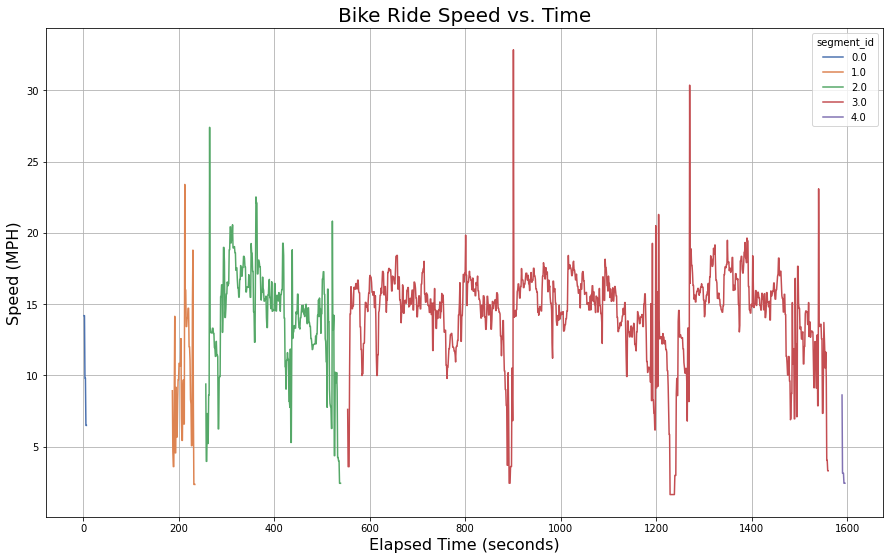

In [14]:
# visualize the jumps of cumulative time 
fig = plt.figure(figsize=(15,9))

_ = sns.lineplot(x='elapsed_time', y='speed', data=df, hue='segment_id', palette='deep')
_ = plt.xlabel('Elapsed Time (seconds)', fontsize=16)
_ = plt.ylabel('Speed (MPH)', fontsize=16)
_ = plt.title('Bike Ride Speed vs. Time', fontsize=20)
_ = plt.grid()

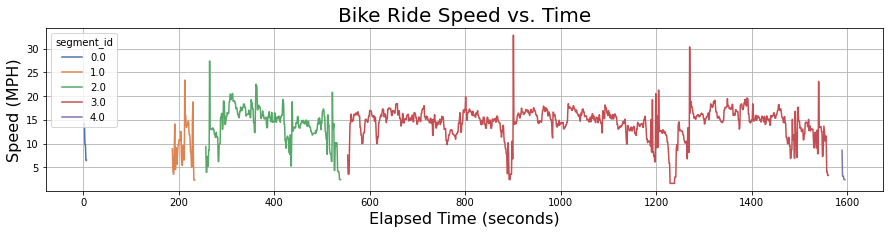

In [111]:
# visualize the jumps of cumulative time 
fig = plt.figure(figsize=(15,3))

_ = sns.lineplot(x='elapsed_time', y='speed', data=df, hue='segment_id', palette='deep')
_ = plt.xlabel('Elapsed Time (seconds)', fontsize=16)
_ = plt.ylabel('Speed (MPH)', fontsize=16)
_ = plt.title('Bike Ride Speed vs. Time', fontsize=20)
_ = plt.grid()

### Is Cruising Flag

In [77]:
start_cruising_threshold = 8.0 # MPH
stop_cruising_threshold = 5.0 # MPH

In [112]:
df_temp = df.loc[df['segment_id']==2, ['time', 'elapsed_time','speed']]

In [113]:
df_temp.head()

,time,elapsed_time,speed
55,2020-01-02 14:07:14+00:00,257.0,9.394840
56,2020-01-02 14:07:15+00:00,258.0,3.974345
57,2020-01-02 14:07:16+00:00,259.0,3.974345
58,2020-01-02 14:07:17+00:00,260.0,7.329361
59,2020-01-02 14:07:18+00:00,261.0,5.229723


In [114]:
df_temp['is_cruising'] = (df_temp['speed']>start_cruising_threshold)

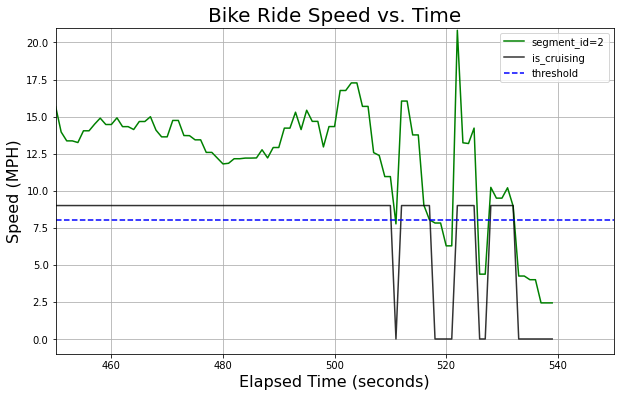

In [122]:
# visualize the jumps of cumulative time 
fig = plt.figure(figsize=(10,6))

_ = sns.lineplot(x='elapsed_time', y='speed', data=df_temp, color='g', label='segment_id=2')
_ = plt.plot(df_temp['elapsed_time'], (start_cruising_threshold+1) * df_temp['is_cruising'], 
             color='k', alpha=0.8, label='is_cruising')
_ = plt.axhline(start_cruising_threshold, color='b', linestyle='--', label='threshold')
_ = plt.xlabel('Elapsed Time (seconds)', fontsize=16)
_ = plt.ylabel('Speed (MPH)', fontsize=16)
_ = plt.title('Bike Ride Speed vs. Time', fontsize=20)
_ = plt.grid()
#_ = plt.xlim([1150, 1300])
_ = plt.xlim([450, 550])
_ = plt.ylim([-1, 21])
_ = plt.legend()

# 3. Elevation & Grade

In [15]:
# We must double check the units of the elevation. 
# It does not look like the units displayed on Strava's website, but is most likely in meters
meters_to_feet = 3.281
df['elevation'] = df['elevation'] * meters_to_feet

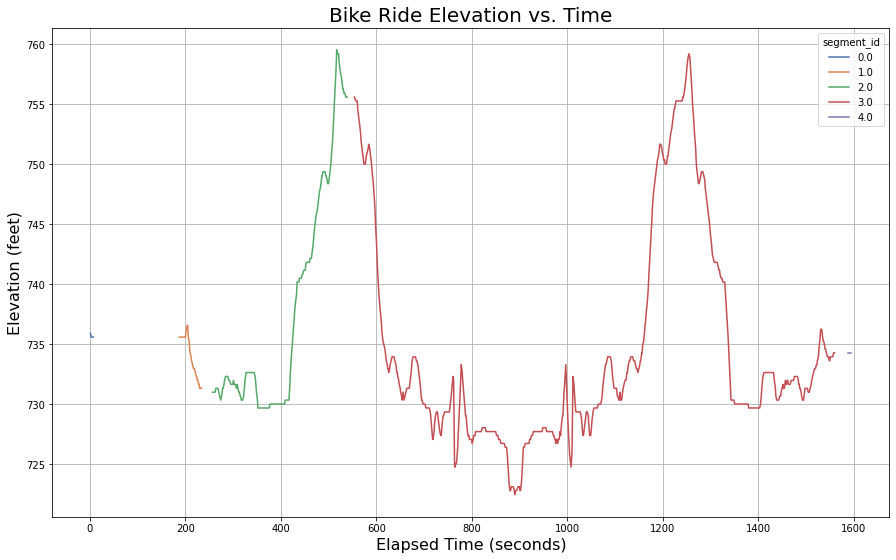

In [16]:
# visualize the jumps of cumulative time 
fig = plt.figure(figsize=(15,9))

_ = sns.lineplot(x='elapsed_time', y='elevation', data=df, hue='segment_id', palette='deep')
_ = plt.xlabel('Elapsed Time (seconds)', fontsize=16)
_ = plt.ylabel('Elevation (feet)', fontsize=16)
_ = plt.title('Bike Ride Elevation vs. Time', fontsize=20)
_ = plt.grid()

### Terrain Gradient

In [17]:
def compute_grade(df, fill_first=0.0):
    df = df.copy()
    
    # create an elevation difference
    feet_to_miles = 1.0 / 5280.0
    df['delta_ele'] = df['elevation'].diff() * feet_to_miles
    df['delta_ele'] = df['delta_ele'].fillna(fill_first)
    
    # create the grade column as a percent
    df['grade'] = 100.0 * (df['delta_ele'] / df['delta_dist'])
    
    # drop the elevation difference
    df.drop(['delta_ele'], axis=1, inplace=True)
    
    return df

In [18]:
df = compute_grade(df)

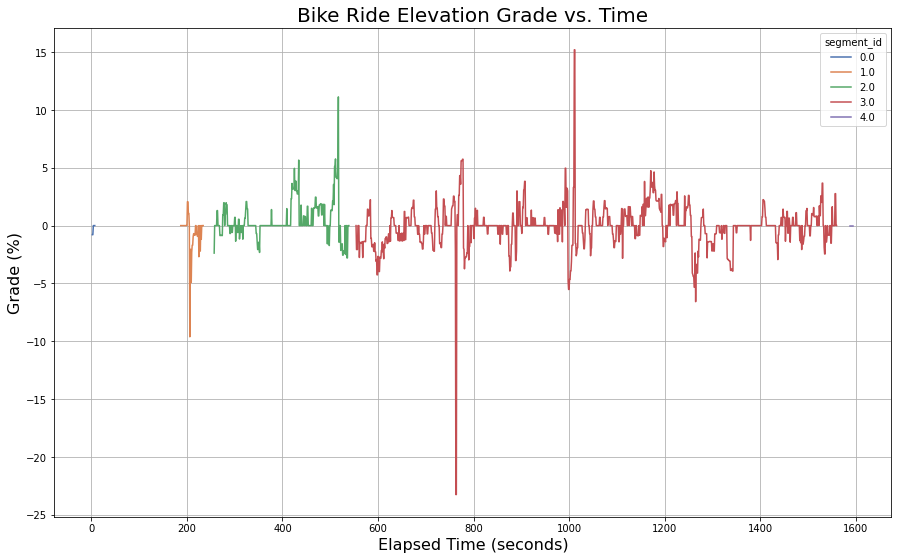

In [19]:
# visualize the jumps of cumulative time 
fig = plt.figure(figsize=(15,9))

_ = sns.lineplot(x='elapsed_time', y='grade', data=df, hue='segment_id', palette='deep')
_ = plt.xlabel('Elapsed Time (seconds)', fontsize=16)
_ = plt.ylabel('Grade (%)', fontsize=16)
_ = plt.title('Bike Ride Elevation Grade vs. Time', fontsize=20)
_ = plt.grid()

### Elapsed Elevation Ascent & Descent

In [62]:
def compute_cumulative_elevation_changes(df, fill_first=0.0):
    df = df.copy()
    
    # create an elevation difference
    df['delta_ele'] = df['elevation'].diff()
    df['delta_ele'] = df['delta_ele'].fillna(fill_first)
    
    # create delta ascent and delta descent columns
    df['delta_ascent'] = df.loc[df['delta_ele']>=0, 'delta_ele']
    df['delta_descent'] = df.loc[df['delta_ele']<=0, 'delta_ele']
    
    # create the cumulative versions
    df['elapsed_ascent'] = df['delta_ascent'].cumsum()
    df['elapsed_ascent'] = df['elapsed_ascent'].interpolate() # fill in any blanks
    df['elapsed_descent'] = df['delta_descent'].cumsum()
    df['elapsed_descent'] = np.abs(df['elapsed_descent'].interpolate()) # fill in any blanks
    
    # create the total elevation change column
    df['elapsed_elevation'] = df['elapsed_ascent'] + df['elapsed_descent']
        
    # drop the elevation differences
    df.drop(['delta_ele','delta_ascent','delta_descent'], axis=1, inplace=True)
    
    return df

In [64]:
df = compute_cumulative_elevation_changes(df)

In [66]:
df.tail()

,time,ride_id,segment_id,elevation,latitude,longitude,elapsed_time,delta_time,moving_time,delta_dist,elapsed_distance,speed,grade,elapsed_ascent,elapsed_descent,elapsed_elevation
1347,2020-01-02 14:29:28+00:00,2.975587e+09,4.0,734.2878,40.042940,-83.027759,1591.0,1.0,1348.0,0.000873,5.273342,3.142551,0.0,137.1458,138.7863,275.9321
1348,2020-01-02 14:29:29+00:00,2.975587e+09,4.0,734.2878,40.042928,-83.027765,1592.0,1.0,1349.0,0.000873,5.274215,3.142551,0.0,137.1458,138.7863,275.9321
1349,2020-01-02 14:29:30+00:00,2.975587e+09,4.0,734.2878,40.042937,-83.027759,1593.0,1.0,1350.0,0.000678,5.274892,2.439775,0.0,137.1458,138.7863,275.9321
1350,2020-01-02 14:29:31+00:00,2.975587e+09,4.0,734.2878,40.042945,-83.027753,1594.0,1.0,1351.0,0.000678,5.275570,2.439775,0.0,137.1458,138.7863,275.9321
1351,2020-01-02 14:29:32+00:00,2.975587e+09,4.0,734.2878,40.042954,-83.027747,1595.0,1.0,1352.0,0.000678,5.276248,2.439775,0.0,137.1458,138.7863,275.9321


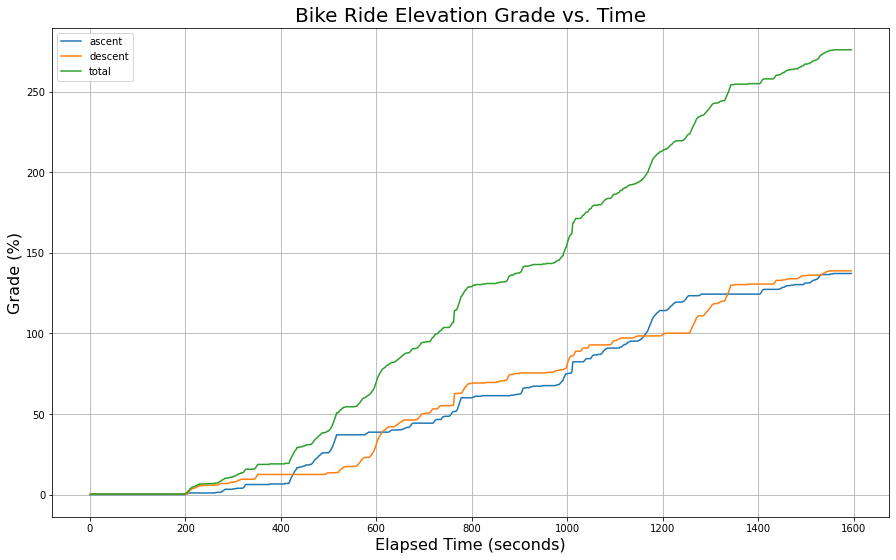

In [68]:
# visualize the jumps of cumulative time 
fig = plt.figure(figsize=(15,9))

_ = sns.lineplot(x='elapsed_time', y='elapsed_ascent', data=df, label='ascent')
_ = sns.lineplot(x='elapsed_time', y='elapsed_descent', data=df, label='descent')
_ = sns.lineplot(x='elapsed_time', y='elapsed_elevation', data=df, label='total')
_ = plt.xlabel('Elapsed Time (seconds)', fontsize=16)
_ = plt.ylabel('Grade (%)', fontsize=16)
_ = plt.title('Bike Ride Elevation Grade vs. Time', fontsize=20)
_ = plt.grid()